# Testing BL-3 and BL-4 ability to produce different products

In [30]:
import reframed
import pandas as pd
import matplotlib_venn
import copy
import cobra

In [31]:
model_rcel = reframed.load_cbmodel("output/GEMs_test/RCell_H10_test.xml")
model_bl3 = reframed.load_cbmodel("output/GEMs_test/clostridiaBL3_test.xml")
model_bl4 = reframed.load_cbmodel("output/GEMs_test/clostridiaBL4_test.xml")


In [32]:
def test_production(model_bl3,model_bl4):   
    models = {"bl3":model_bl3,"bl4":model_bl4}

    FBA_production = {}

    interesting_compounds = ["etoh","lac__L","ac","ppa","but","2mpa","isobuta","ibt","pta","hxa","isocap"]

    for bl_strain, model in models.items(): 
        FBA_production[bl_strain]={}


        reframed.Environment.complete(model,inplace=True)

        for met in interesting_compounds:
            if "R_EX_"+met+"_e" not in model.get_exchange_reactions():
                FBA_production[bl_strain][met]=None
                continue

            sol = reframed.FBA(model,objective={"R_EX_"+met+"_e":1})

            if sol is None:
                FBA_production[bl_strain][met]=None
            else:
                FBA_production[bl_strain][met]=sol.fobj
                
    return FBA_production

In [33]:
pd.DataFrame(test_production(model_bl3,model_bl4))

,bl3,bl4
etoh,NaN,NaN
lac__L,882.141270,10.000000
ac,807.239286,304.705882
ppa,997.851100,10.000000
but,954.585038,510.434783
2mpa,NaN,NaN
isobuta,NaN,NaN
ibt,935.533366,-0.000000
pta,695.126529,165.667509
hxa,581.698579,325.709459


In [34]:
media = pd.read_csv("https://raw.githubusercontent.com/cdanielmachado/carveme/master/carveme/data/input/media_db.tsv",sep="\t")

media_m9_o2 = list(media[media.medium=="M9[-O2]"].compound.values)

media_m9_o2.append("lac__L")
media_m9_o2.remove("glc__D")

In [35]:
env_m9_o2 = reframed.Environment.from_reactions(["R_EX_"+rxn+"_e" for rxn in media_m9_o2])

##### BL-3 maximization of hxa

In [36]:
objective = {"R_EX_hxa_e":1}

env_m9_o2.apply(model_bl3,inplace=True,exclusive=True)

sol_bl3 = reframed.pFBA(model_bl3,objective=objective)

/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_na1_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ni2_e
  warn(f'Exchange reaction not in model: {r_id}')


In [37]:
sol_bl3.show_values(pattern="R_EX_",sort=True)

R_EX_lac__L_e -10
R_EX_h_e     -7.27273
R_EX_so4_e   -0.454545
R_EX_h2s_e    0.454545
R_EX_hxa_e    3.63636
R_EX_h2o_e    8.18182
R_EX_co2_e    8.18182


In [38]:

sol_bl3 = {rxn[2:]:value for rxn,value in sol_bl3.values.items()}
pd.Series(sol_bl3).to_json("escher/hxa_bl3_m9.json")

##### BL-4 maximization of hxa

In [39]:
objective = {"R_EX_hxa_e":1}

env_m9_o2.apply(model_bl4,inplace=True,exclusive=True)

sol_bl4 = reframed.pFBA(model_bl4,objective=objective)

In [40]:
sol_bl4.show_values(pattern="R_EX_",sort=True)

##### Question: why isn't BL-4 able to produce caproate from lactate? 

In [41]:
sol_df = pd.Series(sol_bl3)

active_rxns = sol_df[abs(sol_df)>1e-6].index.values

In [42]:
env_m9_o2.apply(model_bl3,inplace=True,exclusive=True)
objective = {"R_EX_hxa_e":1}


essential_hxa = {}
for rxn in active_rxns:
    constraints = {"R_"+rxn:0}
    
    sol_essential = reframed.FBA(model_bl3,objective=objective,constraints=constraints)
    essential_hxa[rxn] = sol_essential.fobj

**Find essential reactions for hxa prod in BL-3**

In [43]:
essential_hxa_df = pd.DataFrame(pd.Series(essential_hxa),columns=["hxa prod"])
essential_hxa_df[essential_hxa_df["hxa prod"].abs()<1e-6]

,hxa prod
ACACT2r,-0.0
ECOAH2,-0.0
H2St1,-0.0
LACLt2,-0.0
LDH_L,-0.0
PAPSR,-0.0
PAPSSH,-0.0
SO3R,-0.0
SO4t2,-0.0
TRDR,-0.0


In [44]:
essential_hxa_rxns = essential_hxa_df[essential_hxa_df["hxa prod"].abs()<1e-6].index.values

**Compare with BL-4**

In [45]:
essential_not_in_bl4 = []

for rxn in essential_hxa_rxns:
    if rxn not in model_bl4.reactions:
        essential_not_in_bl4.append(rxn)
essential_not_in_bl4

['ACACT2r',
 'ECOAH2',
 'H2St1',
 'LACLt2',
 'LDH_L',
 'PAPSR',
 'PAPSSH',
 'SO3R',
 'SO4t2',
 'TRDR',
 'EX_co2_e',
 'EX_h2o_e',
 'EX_h2s_e',
 'EX_hxa_e',
 'EX_lac__L_e',
 'EX_so4_e',
 'HXAdiff']

### Caproate production

In [5]:
model_bl3.metabolite_reaction_lookup()["M_hxa_c"]

{'R_FACOAL60i': -1.0, 'R_HXCT': -1.0, 'R_HXAdiff': -1.0}

In [6]:
model_bl4.metabolite_reaction_lookup()["M_hxa_c"]

{'R_HXCT': -1.0, 'R_HXAdiff': -1.0}

### Butyrate production

In [7]:
model_bl3.metabolite_reaction_lookup()["M_but_c"]

{'R_BUTCT': -1.0, 'R_BUTKr': -1.0, 'R_BUTt': -1.0, 'R_HMR_0156': -1.0}

In [8]:
model_bl4.metabolite_reaction_lookup()["M_but_c"]

{'R_BUTCT': -1.0, 'R_BUTKr': -1.0, 'R_BUTdiff': -1.0}

## Escher maps

In [9]:
model_bl3_c = cobra.io.read_sbml_model("output/GEMs_test/clostridiaBL3_test.xml")

Adding exchange reaction EX_15dap_e with default bounds for boundary metabolite: 15dap_e.
Adding exchange reaction EX_25dkglcn_e with default bounds for boundary metabolite: 25dkglcn_e.
Adding exchange reaction EX_2ddglcn_e with default bounds for boundary metabolite: 2ddglcn_e.
Adding exchange reaction EX_4abut_e with default bounds for boundary metabolite: 4abut_e.
Adding exchange reaction EX_4abutn_e with default bounds for boundary metabolite: 4abutn_e.
Adding exchange reaction EX_4abz_e with default bounds for boundary metabolite: 4abz_e.
Adding exchange reaction EX_4ahmmp_e with default bounds for boundary metabolite: 4ahmmp_e.
Adding exchange reaction EX_4hphac_e with default bounds for boundary metabolite: 4hphac_e.
Adding exchange reaction EX_5drib_e with default bounds for boundary metabolite: 5drib_e.
Adding exchange reaction EX_5mdru1p_e with default bounds for boundary metabolite: 5mdru1p_e.
Adding exchange reaction EX_abg4_e with default bounds for boundary metabolite: ab

In [10]:
cobra.io.save_json_model(model_bl3_c,"escher/bl3.json")

In [11]:
model_bl4_c = cobra.io.read_sbml_model("output/GEMs_test/clostridiaBL4_test.xml")


Adding exchange reaction EX_12ppd__S_e with default bounds for boundary metabolite: 12ppd__S_e.
Adding exchange reaction EX_15dap_e with default bounds for boundary metabolite: 15dap_e.
Adding exchange reaction EX_4abut_e with default bounds for boundary metabolite: 4abut_e.
Adding exchange reaction EX_4abz_e with default bounds for boundary metabolite: 4abz_e.
Adding exchange reaction EX_4abzglu_e with default bounds for boundary metabolite: 4abzglu_e.
Adding exchange reaction EX_4hba_e with default bounds for boundary metabolite: 4hba_e.
Adding exchange reaction EX_5mdru1p_e with default bounds for boundary metabolite: 5mdru1p_e.
Adding exchange reaction EX_LalaDgluMdapDala_e with default bounds for boundary metabolite: LalaDgluMdapDala_e.
Adding exchange reaction EX_abg4_e with default bounds for boundary metabolite: abg4_e.
Adding exchange reaction EX_ac_e with default bounds for boundary metabolite: ac_e.
Adding exchange reaction EX_acald_e with default bounds for boundary metabol

In [12]:
cobra.io.save_json_model(model_bl4_c,"escher/bl4.json")

### BL-3 

In [19]:

rxns_bl3_has_genes = {}
for rxn in model_bl3.reactions:
    if len(model_bl3.reactions[rxn].get_genes())==0:
        rxns_bl3_has_genes[rxn]=0
    else:
        rxns_bl3_has_genes[rxn]=1
        
rxns_bl3_has_genes = {rxn[2:]:value for rxn,value in rxns_bl3_has_genes.items()}

In [20]:
pd.Series(rxns_bl3_has_genes).to_json("escher/rxns_bl3_has_genes.json")

**Green means that it has the gene, while orange means that it's in model but NO gene. Red means that it does not**

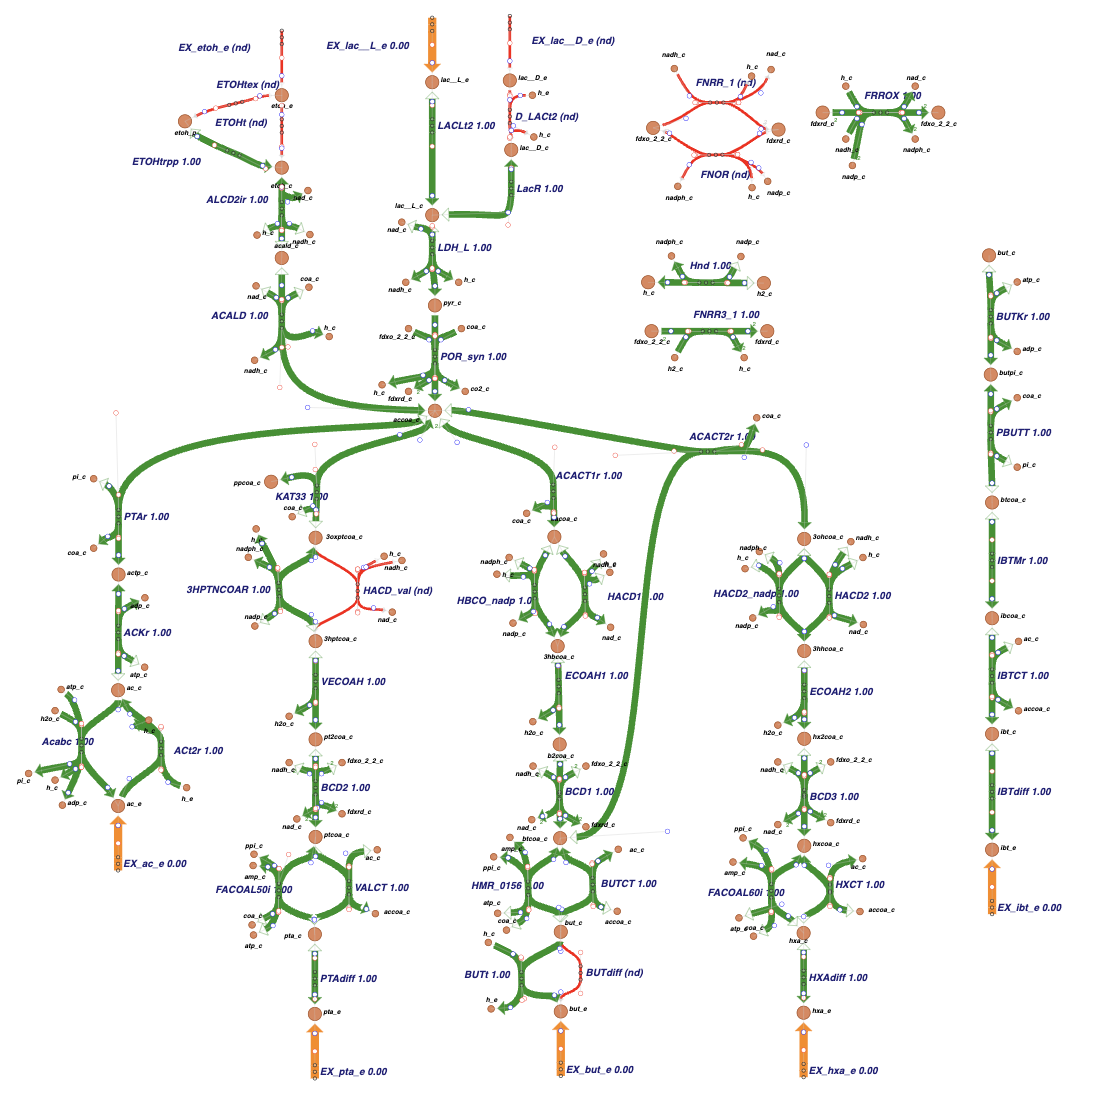

In [28]:
rxns_bl4_has_genes = {}
for rxn in model_bl4.reactions:
    if len(model_bl4.reactions[rxn].get_genes())==0:
        rxns_bl4_has_genes[rxn]=0
    else:
        rxns_bl4_has_genes[rxn]=1
        
rxns_bl4_has_genes = {rxn[2:]:value for rxn,value in rxns_bl4_has_genes.items()}

In [29]:
pd.Series(rxns_bl4_has_genes).to_json("escher/rxns_bl4_has_genes.json")

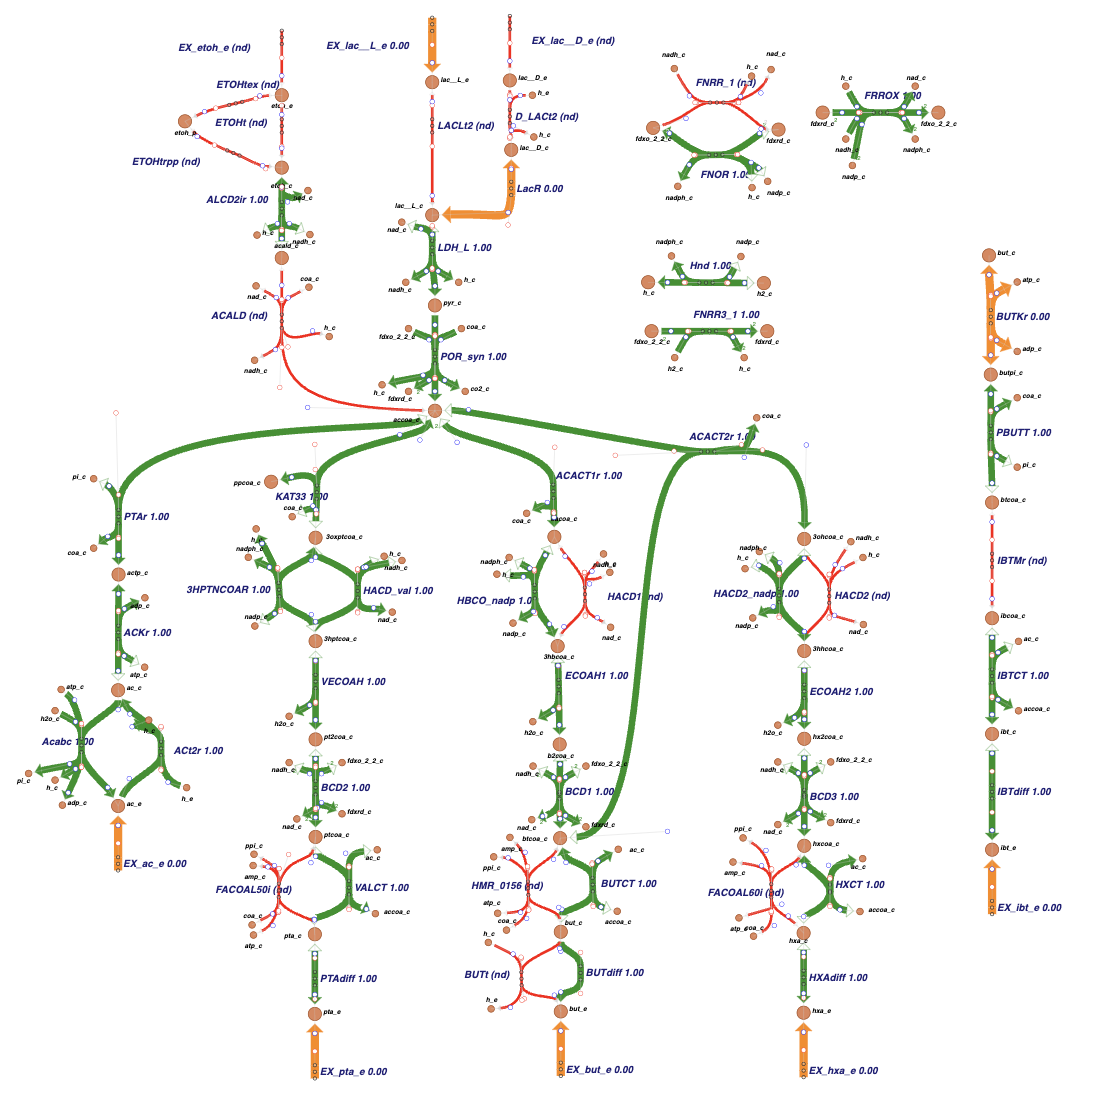